# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
rnd_seed = 13

In [3]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
data[:6]

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0


В таблице предсталены столбцы с звонками, минутами разговора, количеством сообщений и количеством использованного трафика. Результирующая колонка содержит булево значение: 1 если новый тариф "Ультра", 0 - "Смарт"

In [5]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
data.duplicated().sum()

0

данные не имеют пропусков и дубликатов. 

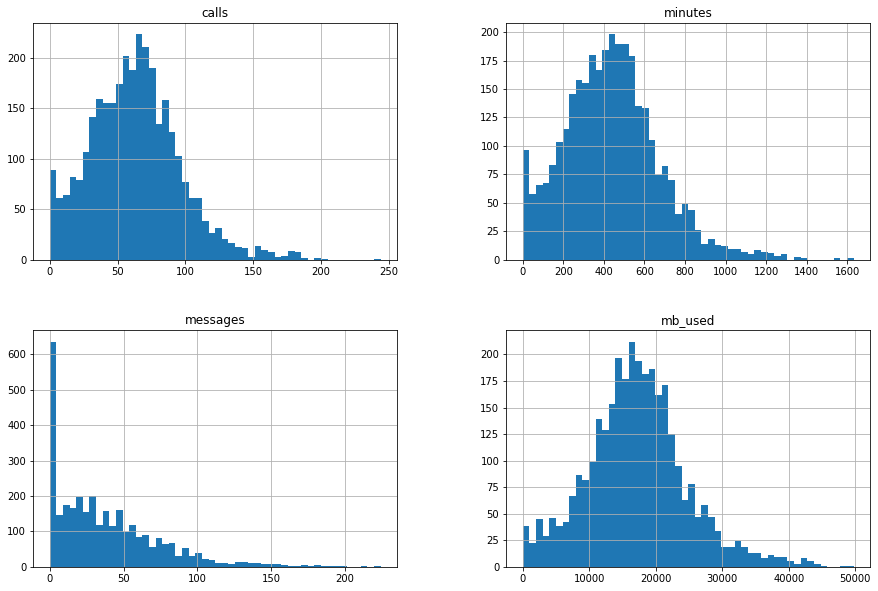

In [7]:
data.iloc[:,:4].hist(figsize=(15,10), bins = 50);

классы имеют соотношение  30.65  к  69.35


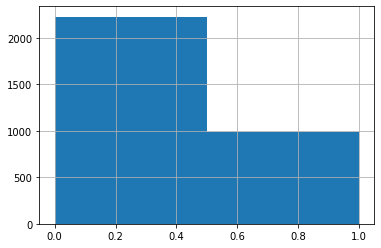

In [8]:
balance = (data['is_ultra'].sum() / data['is_ultra'].count() * 100).round(2)
data['is_ultra'].hist(bins = 2);
print('классы имеют соотношение ', balance, ' к ', 100-balance)

Распределения имеют нормальный вид, без аномальных значений. Модель имеющую точность > 69% можно будет считать работающей.

## Разбейте данные на выборки

Для выполнения задачи будет выделено три набора данных: тренировочная, тестовая и валидационная.
На тренировочной выборке модели будут проходить обучение. На валидационной будет проверено поведение модели с целью выявления признаков переобучения, тестовая выборка покажет итоговый результат работы модели.

In [9]:
X, y = data.iloc[:,:4], data.iloc[:,-1]

In [10]:
X.shape, y.shape

((3214, 4), (3214,))

In [11]:
X_train, X_vrf, y_train, y_vrf = train_test_split(X, y, train_size = 0.6, random_state = rnd_seed)

In [12]:
X_test, X_valid, y_test, y_valid = train_test_split(X_vrf, y_vrf, train_size = 0.5, random_state = rnd_seed)

In [13]:
for value in (X_train, y_train, X_test, X_valid, y_test, y_valid):
    print(value.shape)

(1928, 4)
(1928,)
(643, 4)
(643, 4)
(643,)
(643,)


## Исследуйте модели

Задача модели состоит в опредлении подходящего тарифа: "смарт" или "ультра". 
В данных есть резутаты решений клиентов о выборе тарифов. Это будут обучающие данные. 
Категорий целевого признака всего две. Решаем задачу бинарной классификации. 
Для обучения применим модель дерева решений, случайного леса и метод логистической регресси.

In [14]:
from sklearn.metrics import accuracy_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Дерево решений

In [15]:
def getBestDTCmodel(depth, rnd_seed, min_sample):
    result = 0
    best_result = 0
    best_model = None
    for i in range(1, depth+1):
        for crit in ["gini", "entropy"]:
            for smp in range(2, min_sample+1):
                model = DecisionTreeClassifier(random_state = rnd_seed, max_depth = i, min_samples_split = smp, criterion = crit)
                model.fit(X_train, y_train)
                result = accuracy_score(y_valid, model.predict(X_valid))
                if result > best_result:
                    best_model = model
                    best_result = result
    print("Accuracy лучшей модели:", best_result)
    return best_model
    

In [16]:
modelDTC = getBestDTCmodel(10, rnd_seed, 20)

Accuracy лучшей модели: 0.80248833592535


Дерево решений дало удовлетворительный результат для задачи, 
но стоит попробовать и другие модели.

### Случайный лес

In [17]:
def getBestRFCmodel(estimators, rnd_seed, min_sample):
    result = 0
    best_result = 0
    best_model = None
    for i in range(1, estimators+1):
        for crit in ["gini", "entropy"]:
            for smp in range(2, min_sample+1):
                model = RandomForestClassifier(random_state = rnd_seed, n_estimators = i, min_samples_split = smp, criterion = crit)
                model.fit(X_train, y_train)
                result = model.score(X_valid, y_valid)
                if result > best_result:
                    best_model = model
                    best_result = result
    print("Accuracy лучшей модели:", best_result)
    return best_model
    

In [18]:
modelRFC = getBestRFCmodel(10, rnd_seed, 30)

Accuracy лучшей модели: 0.8195956454121306


Работа модели так-же дала неплохой результат.

### Логистическая регрессия

In [19]:
def getLRmodel(rnd_seed, solvers, iter_value):
    top_acc = -1.0
    param = []
    for solver in solvers:
        for value in range(iter_value-1, iter_value, 100):
            for class0 in range(10, 100, 20):
                for class1 in range(10, 100, 20):
                    for regularize in range(10, 100, 10):
                        result = 0
                        model = LogisticRegression(
                            solver=solver, 
                            max_iter=value, 
                            random_state = rnd_seed,
                            class_weight = {0: class0/100, 1: class1/100},
                            C = regularize/100
                            ) 
                        model.fit(X_train, y_train)
                        result = model.score(X_valid, y_valid)
                        if top_acc < result:
                            top_acc = result
                            param = [top_acc, solver, class0, class1, regularize]
    print(param)
    return model
    

In [20]:
modelLR = getLRmodel(rnd_seed, ['lbfgs', 'liblinear', 'saga'], 1000)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[0.744945567651633, 'liblinear', 70, 90, 30]


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


## Проверьте модель на тестовой выборке

In [21]:
print("Тестовое предсказание модели дерева решений: ", accuracy_score(y_test, modelDTC.predict(X_test)))
print("Тестовое предсказание модели случайного леса: ", accuracy_score(y_test, modelRFC.predict(X_test)))
print("Тестовое предсказание модели логистической регрессии: ", accuracy_score(y_test, modelLR.predict(X_test)))

Тестовое предсказание модели дерева решений:  0.7869362363919129
Тестовое предсказание модели случайного леса:  0.7947122861586314
Тестовое предсказание модели логистической регрессии:  0.687402799377916


## Вывод

В ходе работы было исследовано три модели машинного обучения на предварительно подготовленных данных. 
В ходе обучения модели были перебраны гиперпараметры и определена лучшая конфигурация для каждой модели. Модели дерева решений и случайного леса показали адекватный результат. В модели логистической регрессии точность находится на уровне порога адекватности, похоже она не сработала.